In [1]:
from keras import optimizers
from keras.layers import Dense, Activation
from keras.models import load_model
from keras.models import Sequential
from train import mnist_train_test_split
from util import get_mnist_data
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as skio
%matplotlib inline

/home/giulio/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = load_model('mnist_mlp_autoencoder.h5')
encoder_model = Sequential()
encoder_model.add(Dense(units=200, input_dim=784,
                        weights=model.layers[0].get_weights()))
encoder_model.add(Activation('tanh'))
encoder_model.add(Dense(units=100,
                        weights=model.layers[2].get_weights()))
encoder_model.add(Activation('tanh'))
decoder_model = Sequential()
decoder_model.add(Dense(units=200, input_dim=100,
                        weights=model.layers[4].get_weights()))
decoder_model.add(Activation('tanh'))
decoder_model.add(Dense(units=784,
                        weights=model.layers[6].get_weights()))
decoder_model.add(Activation('sigmoid'))

In [3]:
data, labels = get_mnist_data()
train_x, train_y, test_x, test_y = mnist_train_test_split(data, labels)
train_x, test_x = train_x / 255., test_x / 255.

### Compute and Visualize Decoded Average Encodings for Test Examples

In [4]:
test_encodings = encoder_model.predict(test_x)
average_encodings = {}
for label in range(10):
    class_mean_encoding = np.mean(test_encodings[np.where(labels[60000:] == label)], axis=0)
    average_encodings[label] = class_mean_encoding
average_class_decoded = {}
for label in range(10):
    decoded_class_mean = decoder_model.predict(average_encodings[label].reshape(1, -1)).reshape(28, 28)
    average_class_decoded[label] = decoded_class_mean

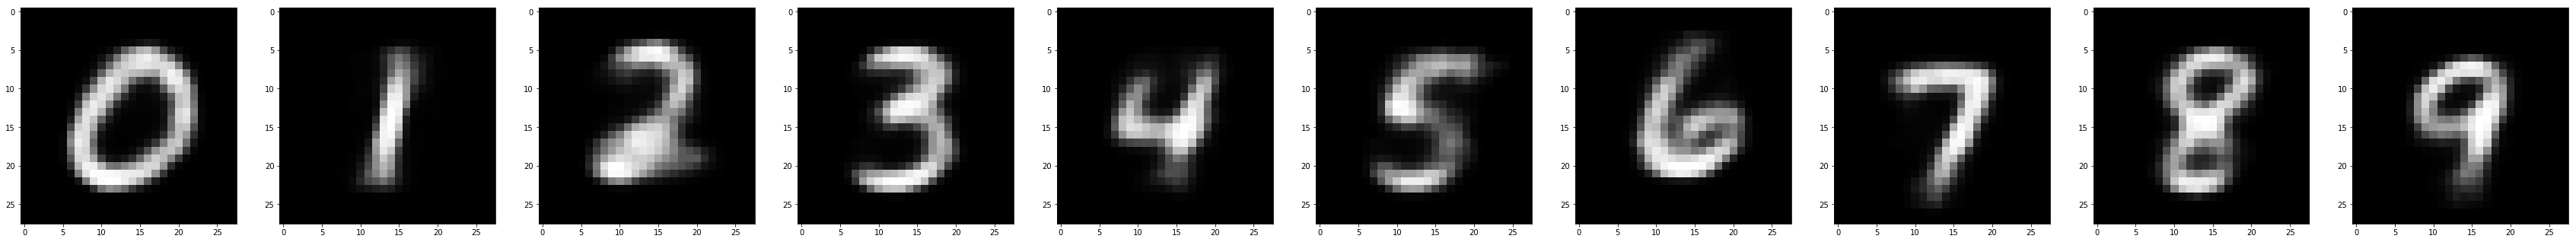

In [5]:
fig, axes = plt.subplots(1, 10, figsize=(60, 6))
for i in range(10):
    ax = axes.flatten()[i]
    ax.imshow(average_class_decoded[i], cmap=plt.cm.gray)

### Interpolate Between Randomly Chosen Points

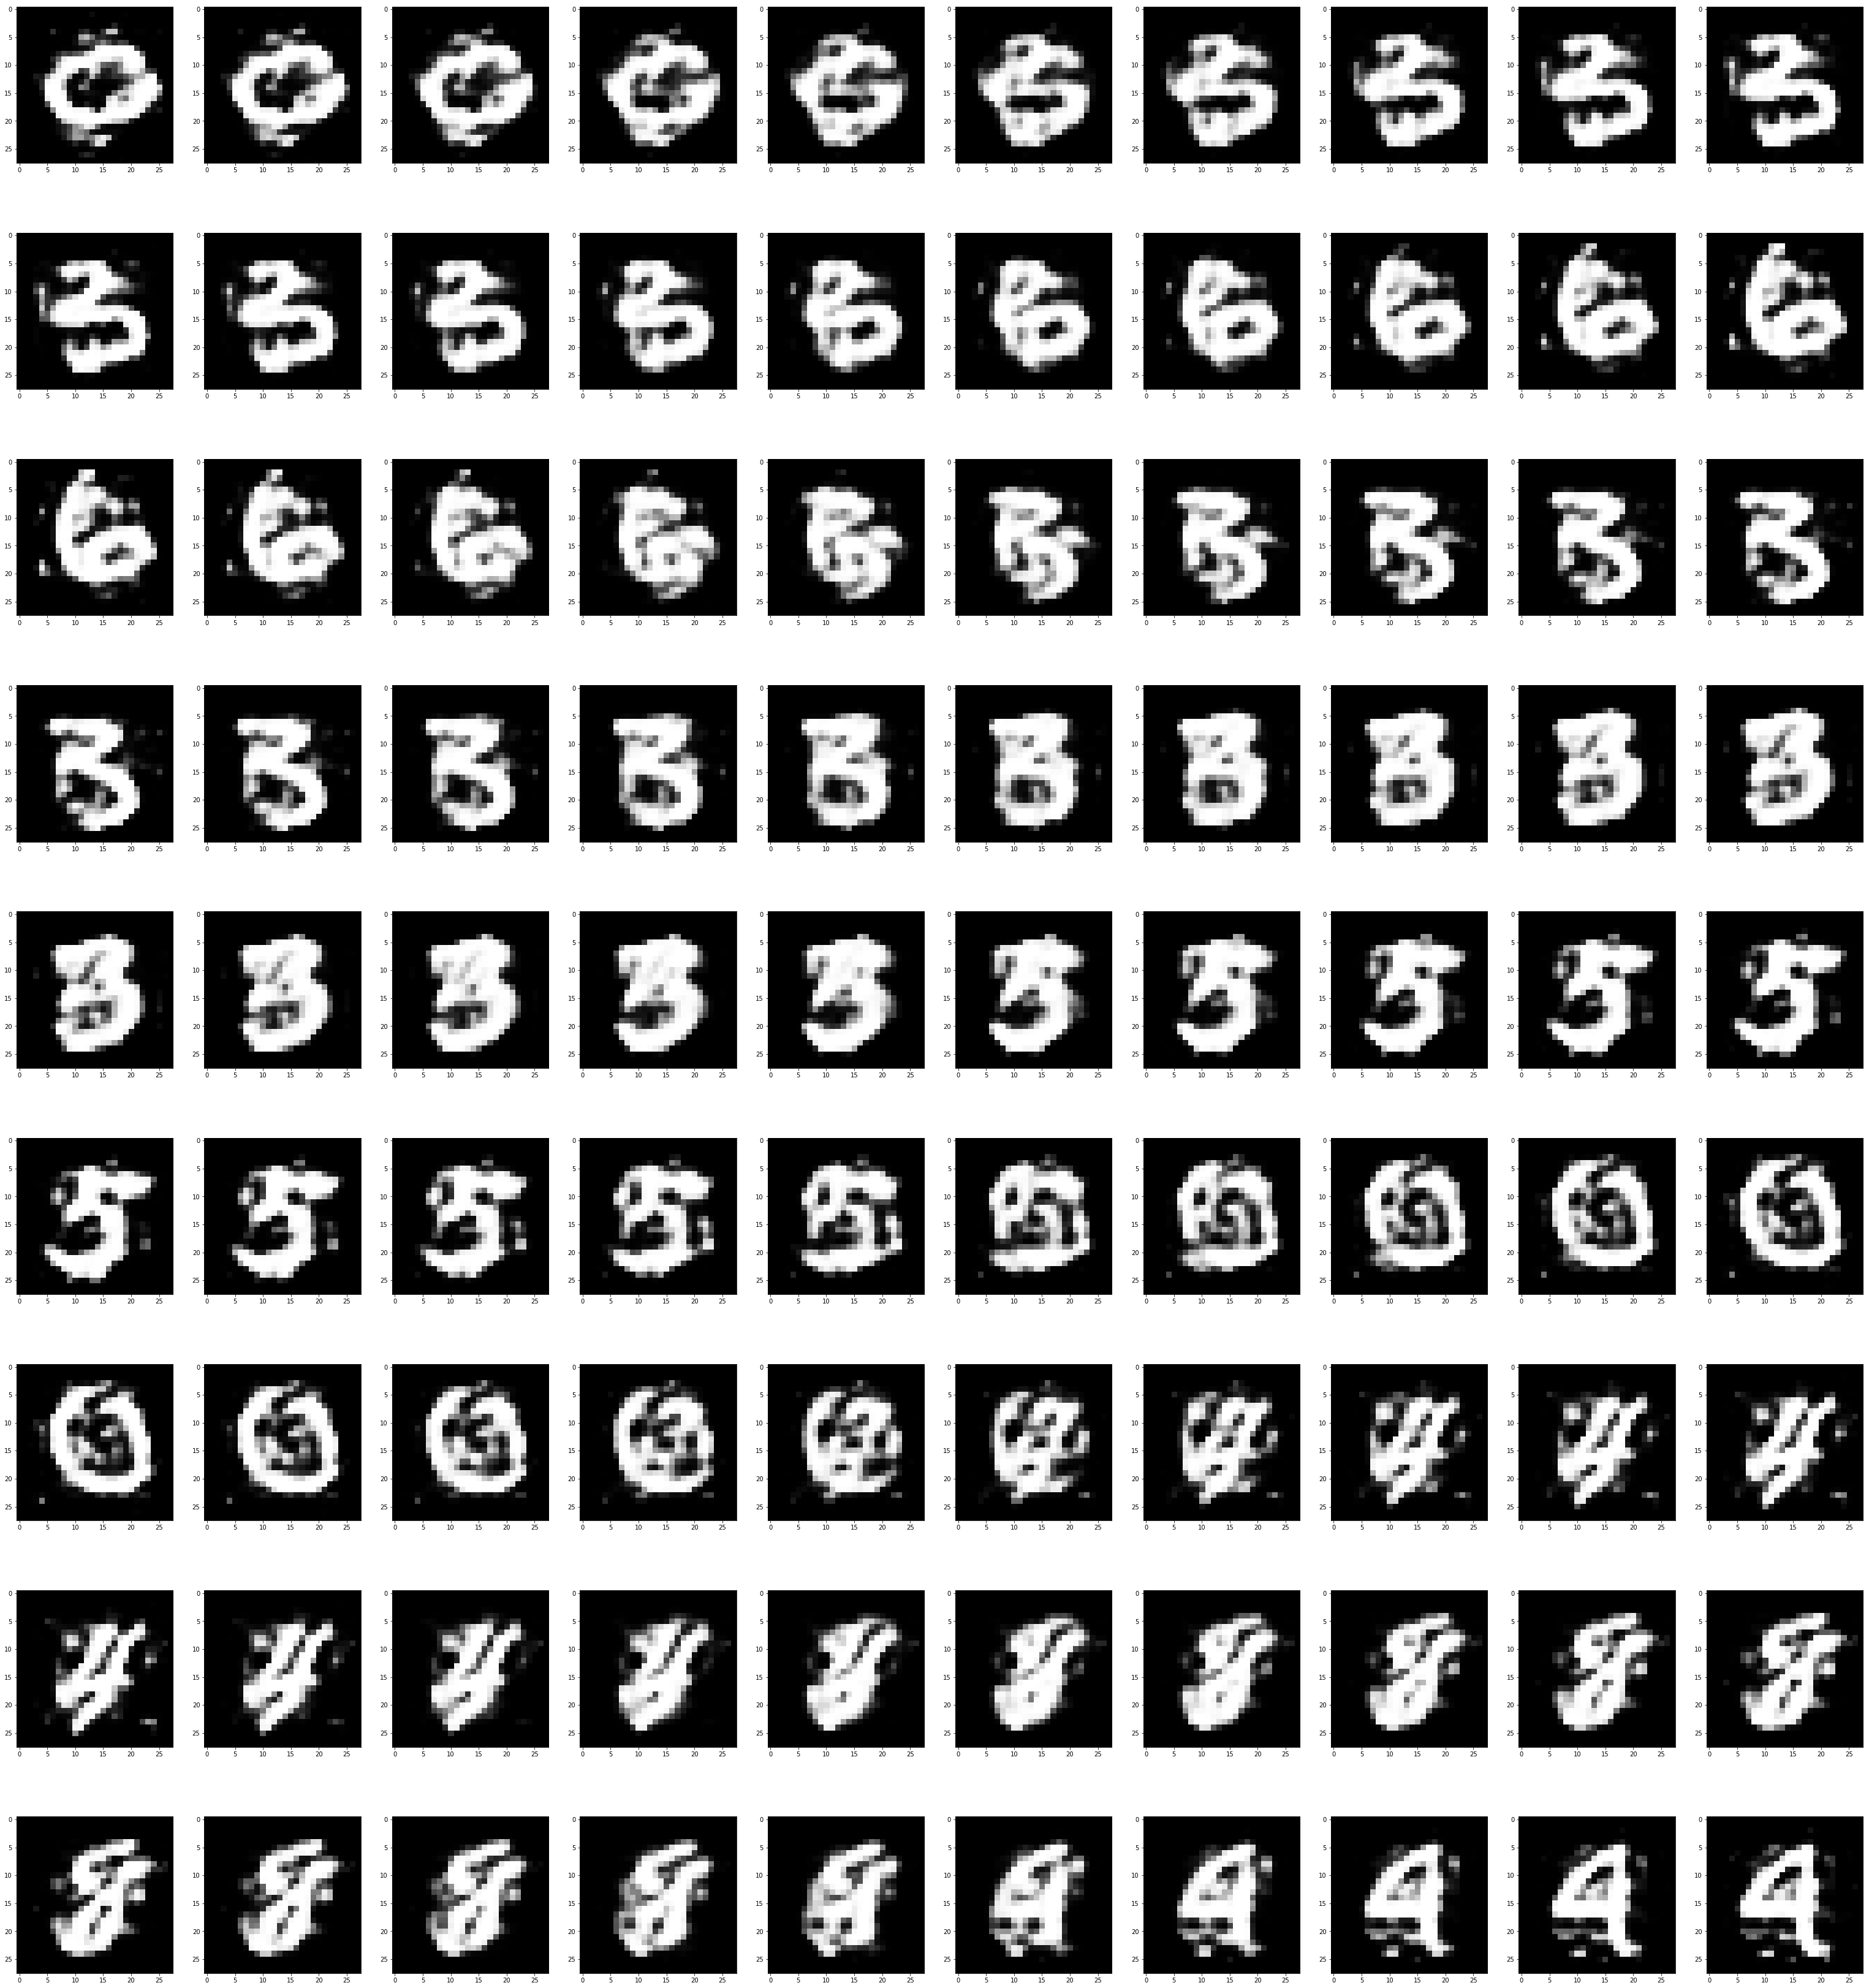

In [64]:
n_data_points = 10
n_interp_points = 10
test_data_points = data[60000:]
src_data = test_data_points[np.random.randint(0, len(test_data_points))]
fig, axes = plt.subplots(n_data_points - 1, n_interp_points, figsize=(6 * (n_data_points - 1), 6 * n_interp_points))
for i in range(n_data_points - 1):
    dst_data = test_data_points[np.random.randint(0, len(test_data_points))]
    src_encoding = encoder_model.predict(src_data.reshape(1, -1))[0]
    dst_encoding = encoder_model.predict(dst_data.reshape(1, -1))[0]
    for j in range(n_interp_points):
        alpha = float(j) / (n_interp_points - 1)
        interp_encoding = (1 - alpha) * src_encoding + alpha * dst_encoding
        interp_image = decoder_model.predict(interp_encoding.reshape(1, -1)).reshape(28, 28)
        axes[i, j].imshow(interp_image, cmap=plt.cm.gray)
    src_data = dst_data

### Train Linear Classifier on Encodings

In [12]:
linear_model = Sequential()
linear_model.add(Dense(units=10, input_dim=100))
linear_model.add(Activation('softmax'))
linear_model.compile(loss='categorical_crossentropy',
                     optimizer='adam', metrics=['accuracy'])
train_encodings = encoder_model.predict(train_x)
test_encodings = encoder_model.predict(test_x)
linear_model.fit(train_encodings, train_y, epochs=20, batch_size=32)
linear_model.evaluate(test_encodings, test_y, batch_size=128)

Epoch 1/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.9350 - acc: 0.7630
Epoch 2/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.4542 - acc: 0.8800
Epoch 3/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.3831 - acc: 0.8929
Epoch 4/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.3539 - acc: 0.9003
Epoch 5/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.3382 - acc: 0.9038
Epoch 6/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.3288 - acc: 0.9059
Epoch 7/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.3225 - acc: 0.9077
Epoch 8/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.3180 - acc: 0.9085
Epoch 9/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.3147 - acc: 0.9095
Epoch 10/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.3121 - acc: 0.9101

[0.2962145707845688, 0.9166]